<a href="https://colab.research.google.com/github/juliangaleano189-cloud/deep-learning-2-TdeA/blob/main/guias/Guia_02_Redes_Neuronales_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Guia 02: Redes Neuronales con Keras - Tu Primera Red Profunda

## Electiva II - Deep Learning | Tecnologico de Antioquia

---

**Objetivo de aprendizaje:** Construir y entrenar redes neuronales multicapa usando TensorFlow/Keras, comprendiendo como la profundidad y la amplitud de la red afectan su capacidad de aprendizaje.

**Conceptos nuevos en esta guia:**
- Redes multicapa (MLP - Perceptron Multicapa)
- Propagacion hacia adelante (Forward Propagation)
- Retropropagacion del error (Backpropagation)
- API Sequential y Functional de Keras
- Compilacion y entrenamiento de modelos
- Hiperparametros: capas, neuronas, epocas

**Prerrequisito:** Guia 01 - Fundamentos de Deep Learning y el Perceptron

**Duracion estimada:** 3 horas

---

> **IMPORTANTE:** Las secciones marcadas con **\u270d\ufe0f** requieren tu respuesta escrita. Estas respuestas son parte de tu evaluacion. No las dejes en blanco.

---

## 1. Configuracion del Entorno

Primero configuremos todas las herramientas que necesitaremos. Si estas trabajando en **Google Colab**, TensorFlow ya viene preinstalado. Si estas en tu maquina local, necesitaras instalarlo.

In [1]:
# Instalacion de TensorFlow (descomentar si es necesario)
# En Google Colab normalmente ya esta instalado
# !pip install tensorflow

In [2]:
# ============================================================
# Importacion de librerias
# ============================================================
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

import time
import warnings
warnings.filterwarnings('ignore')

# Configuracion de estilo para graficas
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Librerias importadas correctamente.")

Librerias importadas correctamente.


In [3]:
# ============================================================
# Verificacion de la version de TensorFlow
# ============================================================
print(f"Version de TensorFlow: {tf.__version__}")
print(f"Version de Keras: {keras.__version__}")
print(f"Version de NumPy: {np.__version__}")

# Verificar si hay GPU disponible
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\nGPU disponible: {gpus}")
    print("El entrenamiento sera mas rapido con GPU.")
else:
    print("\nNo se detecto GPU. Se usara CPU.")
    print("Esto es normal si estas en tu computador sin GPU dedicada.")

Version de TensorFlow: 2.19.0
Version de Keras: 3.10.0
Version de NumPy: 2.0.2

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
El entrenamiento sera mas rapido con GPU.


In [4]:
# ============================================================
# Semilla de reproducibilidad
# ============================================================
# Fijamos una semilla para que todos obtengamos resultados similares.
# Esto es importante en ciencia de datos: necesitamos que los
# experimentos sean reproducibles.

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"Semilla de reproducibilidad fijada en: {SEED}")
print("Esto garantiza que los resultados sean consistentes entre ejecuciones.")

Semilla de reproducibilidad fijada en: 42
Esto garantiza que los resultados sean consistentes entre ejecuciones.


---

## 2. Marco Teorico

### 2.1 Del Perceptron a la Red Multicapa: La Solucion al Problema XOR

En la **Guia 01** construimos un perceptron simple y descubrimos su gran limitacion: **no puede resolver problemas que no son linealmente separables**, como el problema XOR.

Recordemos el problema XOR:

| Entrada 1 | Entrada 2 | Salida XOR |
|:---------:|:---------:|:----------:|
| 0         | 0         | 0          |
| 0         | 1         | 1          |
| 1         | 0         | 1          |
| 1         | 1         | 0          |

Un solo perceptron no puede trazar una unica linea recta que separe los 0s de los 1s en este caso. **La solucion** fue propuesta ya en los anos 80: usar **multiples perceptrones organizados en capas**, creando lo que llamamos una **Red Neuronal Multicapa** o **MLP** (Multi-Layer Perceptron).

La idea es simple pero poderosa:
- **Capa 1 (oculta):** Dos neuronas que aprenden dos fronteras lineales distintas.
- **Capa 2 (salida):** Una neurona que combina las dos fronteras para resolver XOR.

```
Ejemplo de red para XOR:

  Entradas      Capa Oculta      Salida
                 --------
  x1 ---------> | h1     | ------\
       \   /    --------          --------
        \ /                 ---> |  y     |
        / \                 /     --------
       /   \    --------   /
  x2 ---------> | h2     | ------/
                 --------
```

Cada conexion (flecha) tiene un **peso** que se ajusta durante el entrenamiento. La capa oculta transforma los datos en una nueva representacion donde el problema **si es linealmente separable**.

### 2.2 Arquitectura de una Red Neuronal

Una red neuronal se compone de tres tipos de capas:

```
  CAPA DE           CAPAS              CAPA DE
  ENTRADA          OCULTAS             SALIDA
  -------     -------  -------        -------
  | x1  | --> | h1  |  | h4  |  ----> | y1  |
  -------     -------  -------        -------
  -------     -------  -------        -------
  | x2  | --> | h2  |  | h5  |  ----> | y2  |
  -------     -------  -------        -------
  -------     -------  -------        -------
  | x3  | --> | h3  |  | h6  |  ----> | y3  |
  -------     -------  -------        -------

  (3 neuronas)  (3)      (3)          (3 neuronas)
```

1. **Capa de entrada:** Recibe los datos crudos. No hace ningun calculo. El numero de neuronas es igual al numero de caracteristicas de los datos. Para una imagen de 28x28 pixeles, tendriamos 784 neuronas de entrada.

2. **Capas ocultas:** Aqui es donde sucede la "magia". Cada capa oculta transforma la representacion de los datos. Las primeras capas aprenden patrones simples (bordes, texturas) y las capas mas profundas aprenden patrones mas complejos (formas, objetos). Podemos tener 1, 2, 10 o cientos de capas ocultas.

3. **Capa de salida:** Produce la prediccion final. Para clasificacion de 10 digitos, tendremos 10 neuronas (una por cada digito del 0 al 9).

**Terminologia importante:**
- **Red densa (fully connected):** cada neurona de una capa esta conectada a TODAS las neuronas de la capa siguiente.
- **Profundidad:** numero de capas ocultas. Mas capas = red mas "profunda" (de ahi el nombre "Deep Learning").
- **Amplitud:** numero de neuronas por capa.

### 2.3 Propagacion Hacia Adelante (Forward Propagation)

Es el proceso mediante el cual los datos de entrada viajan a traves de la red, capa por capa, hasta producir una salida. En cada neurona ocurre lo siguiente:

**Paso 1 - Combinacion lineal:**

$$z = \sum_{i=1}^{n} w_i \cdot x_i + b = \mathbf{w}^T \mathbf{x} + b$$

Donde:
- $x_i$ son las entradas (o las salidas de la capa anterior)
- $w_i$ son los pesos de las conexiones
- $b$ es el sesgo (bias)
- $z$ es la preactivacion

**Paso 2 - Funcion de activacion:**

$$a = f(z)$$

Donde $f$ es una funcion de activacion no lineal. Las mas comunes son:

- **ReLU** (Rectified Linear Unit): $f(z) = \max(0, z)$ -- la mas usada en capas ocultas
- **Sigmoid:** $f(z) = \frac{1}{1 + e^{-z}}$ -- usada en salida para clasificacion binaria
- **Softmax:** $f(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}$ -- usada en salida para clasificacion multiclase

**Ejemplo concreto de forward propagation:**

Imaginemos una red con 2 entradas, 1 capa oculta de 3 neuronas y 1 salida:

```
Entrada: x = [0.5, 0.8]

Capa oculta (3 neuronas):
  h1 = ReLU(w11*0.5 + w12*0.8 + b1)
  h2 = ReLU(w21*0.5 + w22*0.8 + b2)
  h3 = ReLU(w31*0.5 + w32*0.8 + b3)

Capa de salida (1 neurona):
  y = Sigmoid(w1*h1 + w2*h2 + w3*h3 + b)
```

Esto se puede expresar de forma matricial para toda una capa:

$$\mathbf{a}^{[l]} = f\left(\mathbf{W}^{[l]} \cdot \mathbf{a}^{[l-1]} + \mathbf{b}^{[l]}\right)$$

Donde $l$ indica el numero de capa.

### 2.4 Backpropagation y Descenso de Gradiente

Una vez que la red produce una prediccion (forward propagation), necesitamos saber **que tan equivocada esta** y **como corregirla**. Aqui entran dos conceptos fundamentales:

#### Funcion de perdida (Loss Function)

Mide la diferencia entre la prediccion de la red ($\hat{y}$) y el valor real ($y$).

**Para clasificacion multiclase** usamos **Categorical Cross-Entropy**:

$$L = -\sum_{i=1}^{C} y_i \cdot \log(\hat{y}_i)$$

Donde $C$ es el numero de clases, $y_i$ es 1 si la clase $i$ es la correcta y 0 en caso contrario, y $\hat{y}_i$ es la probabilidad predicha para la clase $i$.

**Para regresion** usamos **Error Cuadratico Medio (MSE)**:

$$L = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

#### Backpropagation (Retropropagacion del error)

Es el algoritmo que calcula **como cada peso contribuye al error**. Funciona usando la **regla de la cadena** del calculo diferencial, propagando el error desde la salida hacia las capas anteriores.

Intuitivamente, es como preguntar: "Si cambio ligeramente este peso, ?cuanto cambia el error total?" Eso es el **gradiente**:

$$\frac{\partial L}{\partial w_{ij}^{[l]}}$$

El gradiente nos dice la **direccion** y **magnitud** del cambio necesario.

#### Descenso de Gradiente

Una vez calculados los gradientes, actualizamos cada peso en la direccion que reduce el error:

$$w_{nuevo} = w_{actual} - \alpha \cdot \frac{\partial L}{\partial w}$$

Donde $\alpha$ es la **tasa de aprendizaje** (learning rate), un hiperparametro que controla que tan grandes son los pasos de actualizacion.

**Analogia:** Imagina que estas en una montana con niebla y quieres llegar al punto mas bajo (valle). No puedes ver el valle, pero puedes sentir la inclinacion del terreno bajo tus pies. El descenso de gradiente es como dar pasos pequenos siempre en la direccion donde el terreno baja mas.

- $\alpha$ muy grande: das saltos enormes y puedes saltar por encima del valle.
- $\alpha$ muy pequeno: avanzas tan lento que nunca llegas.
- $\alpha$ adecuado: llegas al valle de forma eficiente.

**Optimizador Adam:** En la practica, usamos optimizadores mas sofisticados que el descenso de gradiente basico. **Adam** (Adaptive Moment Estimation) adapta la tasa de aprendizaje para cada peso individualmente, lo que generalmente funciona muy bien sin necesidad de ajustar mucho.

### 2.5 Introduccion a Keras

**Keras** es una API de alto nivel para construir y entrenar redes neuronales. Originalmente era una libreria independiente, pero ahora esta integrada en **TensorFlow** como `tf.keras`.

**Ventajas de Keras:**
- Sintaxis simple e intuitiva
- Permite prototipar rapidamente
- Soporta CPU y GPU sin cambiar codigo
- Gran comunidad y documentacion

**Dos formas de construir modelos:**

| Caracteristica | API Sequential | API Functional |
|:--------------|:--------------|:---------------|
| Complejidad | Simple | Mas flexible |
| Tipo de modelos | Lineales (capa tras capa) | Cualquier arquitectura |
| Multiples entradas/salidas | No | Si |
| Conexiones residuales | No | Si |
| Recomendado para | Principiantes, redes simples | Arquitecturas complejas |

**Flujo tipico en Keras:**
1. **Definir** la arquitectura (capas, neuronas, activaciones)
2. **Compilar** el modelo (optimizador, funcion de perdida, metricas)
3. **Entrenar** el modelo con datos (`.fit()`)
4. **Evaluar** el modelo con datos de prueba (`.evaluate()`)
5. **Predecir** con datos nuevos (`.predict()`)

---

## 3. Carga y Exploracion de Datos: MNIST

**MNIST** (Modified National Institute of Standards and Technology) es uno de los datasets mas clasicos en Machine Learning. Contiene **70,000 imagenes** de digitos escritos a mano (0-9), cada una de **28x28 pixeles** en escala de grises.

- **60,000** imagenes de entrenamiento
- **10,000** imagenes de prueba
- **10 clases** (digitos del 0 al 9)

Es el equivalente al "Hola Mundo" del Deep Learning. Si tu red puede clasificar estos digitos, has dado un gran paso.

In [5]:
# ============================================================
# 3.1 Cargar el dataset MNIST
# ============================================================
# Keras tiene MNIST integrado, lo cual facilita mucho la carga.
# Los datos ya vienen divididos en entrenamiento y prueba.

(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = keras.datasets.mnist.load_data()

print("Dataset MNIST cargado exitosamente!")
print(f"\n--- Conjunto de entrenamiento ---")
print(f"  Imagenes (x_train): {x_train_raw.shape}")
print(f"  Etiquetas (y_train): {y_train_raw.shape}")
print(f"\n--- Conjunto de prueba ---")
print(f"  Imagenes (x_test): {x_test_raw.shape}")
print(f"  Etiquetas (y_test): {y_test_raw.shape}")
print(f"\n--- Informacion adicional ---")
print(f"  Tipo de datos de las imagenes: {x_train_raw.dtype}")
print(f"  Valor minimo de un pixel: {x_train_raw.min()}")
print(f"  Valor maximo de un pixel: {x_train_raw.max()}")
print(f"  Clases unicas: {np.unique(y_train_raw)}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dataset MNIST cargado exitosamente!

--- Conjunto de entrenamiento ---
  Imagenes (x_train): (60000, 28, 28)
  Etiquetas (y_train): (60000,)

--- Conjunto de prueba ---
  Imagenes (x_test): (10000, 28, 28)
  Etiquetas (y_test): (10000,)

--- Informacion adicional ---
  Tipo de datos de las imagenes: uint8
  Valor minimo de un pixel: 0
  Valor maximo de un pixel: 255
  Clases unicas: [0 1 2 3 4 5 6 7 8 9]


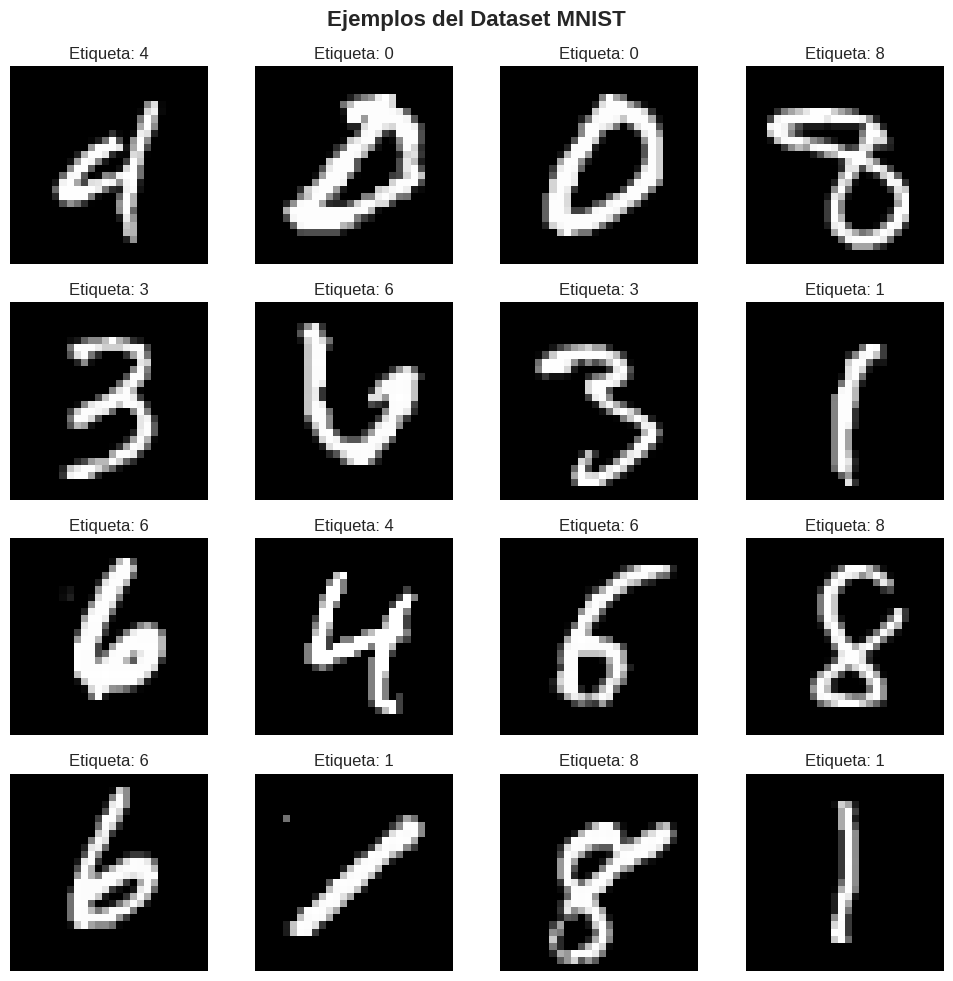

In [6]:
# ============================================================
# 3.2 Visualizar ejemplos del dataset
# ============================================================
# Siempre es buena practica visualizar los datos antes de
# construir cualquier modelo. Veamos una cuadricula de ejemplos.

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('Ejemplos del Dataset MNIST', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    # Seleccionamos un indice aleatorio
    idx = np.random.randint(0, len(x_train_raw))
    ax.imshow(x_train_raw[idx], cmap='gray')
    ax.set_title(f'Etiqueta: {y_train_raw[idx]}', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

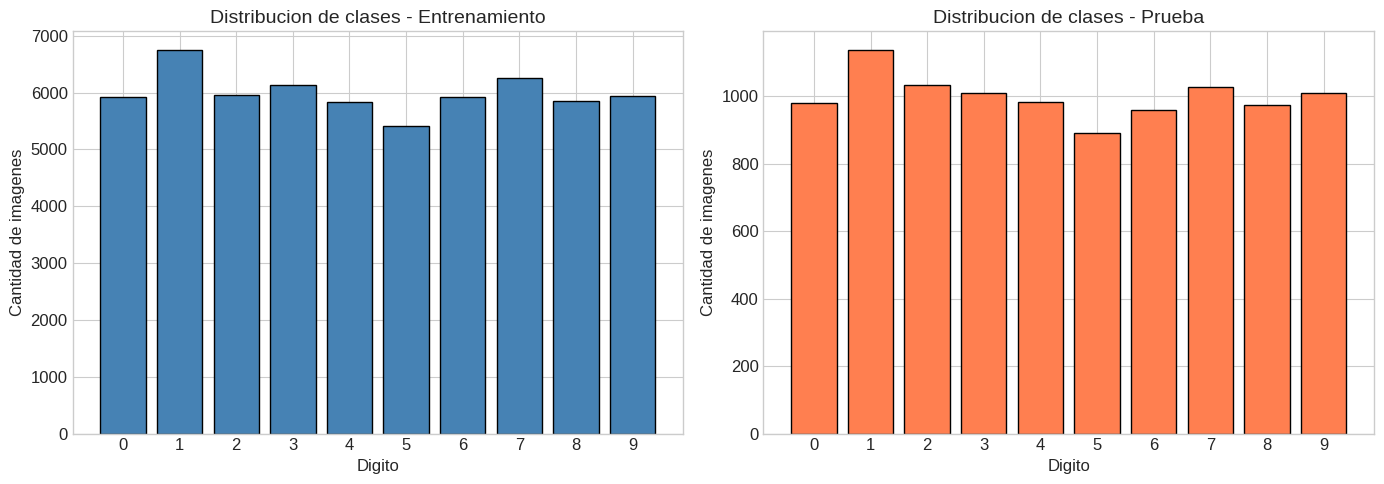

Las clases estan razonablemente balanceadas.
Rango de imagenes por clase (train): 5421 - 6742


In [7]:
# ============================================================
# 3.3 Distribucion de clases
# ============================================================
# Verifiquemos que las clases esten balanceadas
# (que haya una cantidad similar de cada digito).

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribucion en entrenamiento
clases_train, conteos_train = np.unique(y_train_raw, return_counts=True)
axes[0].bar(clases_train, conteos_train, color='steelblue', edgecolor='black')
axes[0].set_title('Distribucion de clases - Entrenamiento', fontsize=14)
axes[0].set_xlabel('Digito')
axes[0].set_ylabel('Cantidad de imagenes')
axes[0].set_xticks(range(10))

# Distribucion en prueba
clases_test, conteos_test = np.unique(y_test_raw, return_counts=True)
axes[1].bar(clases_test, conteos_test, color='coral', edgecolor='black')
axes[1].set_title('Distribucion de clases - Prueba', fontsize=14)
axes[1].set_xlabel('Digito')
axes[1].set_ylabel('Cantidad de imagenes')
axes[1].set_xticks(range(10))

plt.tight_layout()
plt.show()

print("Las clases estan razonablemente balanceadas.")
print(f"Rango de imagenes por clase (train): {conteos_train.min()} - {conteos_train.max()}")

### 3.4 Preprocesamiento de los datos

Antes de alimentar los datos a la red neuronal, necesitamos realizar dos transformaciones fundamentales:

**1. Normalizacion:** Los valores de los pixeles van de 0 a 255. Dividimos entre 255 para llevarlos al rango [0, 1]. Esto ayuda a que:
- Los gradientes sean mas estables durante el entrenamiento
- El optimizador converja mas rapido
- Las funciones de activacion trabajen en su rango optimo

**2. Reshape (aplanamiento):** Las imagenes son matrices de 28x28. Pero una red densa (fully connected) espera un vector unidimensional como entrada. Asi que "aplanaamos" cada imagen de 28x28 a un vector de 784 elementos.

**3. One-hot encoding:** Las etiquetas son numeros (0-9). Para clasificacion multiclase con softmax, necesitamos convertirlas a vectores one-hot. Por ejemplo:
- Digito 3 --> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
- Digito 7 --> [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

In [8]:
# ============================================================
# 3.4 Preprocesamiento
# ============================================================

# --- Paso 1: Normalizacion ---
# Convertimos de uint8 (0-255) a float32 (0.0-1.0)
x_train_norm = x_train_raw.astype('float32') / 255.0
x_test_norm = x_test_raw.astype('float32') / 255.0

print("--- Despues de la normalizacion ---")
print(f"Tipo de dato: {x_train_norm.dtype}")
print(f"Valor minimo: {x_train_norm.min()}")
print(f"Valor maximo: {x_train_norm.max()}")

# --- Paso 2: Reshape (aplanar de 28x28 a 784) ---
x_train = x_train_norm.reshape(-1, 784)  # -1 significa "calcula esta dimension automaticamente"
x_test = x_test_norm.reshape(-1, 784)

print(f"\n--- Despues del reshape ---")
print(f"Forma de x_train: {x_train.shape}  (60000 imagenes, cada una con 784 pixeles)")
print(f"Forma de x_test: {x_test.shape}")

# --- Paso 3: One-hot encoding de las etiquetas ---
num_clases = 10
y_train = to_categorical(y_train_raw, num_clases)
y_test = to_categorical(y_test_raw, num_clases)

print(f"\n--- Despues del one-hot encoding ---")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de y_test: {y_test.shape}")
print(f"\nEjemplo - Digito {y_train_raw[0]}:")
print(f"  Etiqueta original: {y_train_raw[0]}")
print(f"  One-hot encoding:  {y_train[0]}")

--- Despues de la normalizacion ---
Tipo de dato: float32
Valor minimo: 0.0
Valor maximo: 1.0

--- Despues del reshape ---
Forma de x_train: (60000, 784)  (60000 imagenes, cada una con 784 pixeles)
Forma de x_test: (10000, 784)

--- Despues del one-hot encoding ---
Forma de y_train: (60000, 10)
Forma de y_test: (10000, 10)

Ejemplo - Digito 5:
  Etiqueta original: 5
  One-hot encoding:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


---

## 4. Experimentacion Guiada

Ahora viene la parte mas emocionante. Vamos a construir redes neuronales reales usando Keras y experimentar con diferentes configuraciones para entender como afectan al rendimiento.

---

### Experimento 1: Tu Primera Red Neuronal con Keras (Sequential API)

Vamos a construir paso a paso tu primera red neuronal. Sera una red simple pero sorprendentemente efectiva:

```
  Entrada (784)  -->  Capa Oculta (128, ReLU)  -->  Salida (10, Softmax)
```

**Arquitectura:**
- **Entrada:** 784 neuronas (los 784 pixeles de cada imagen)
- **Capa oculta:** 128 neuronas con activacion ReLU
- **Salida:** 10 neuronas con activacion Softmax (una probabilidad por cada digito)

In [9]:
# ============================================================
# EXPERIMENTO 1: Primera red neuronal con Keras
# ============================================================

# --- Paso 1: Definir la arquitectura ---
# Usamos la API Sequential: las capas se apilan una tras otra.

modelo_1 = keras.Sequential([
    # Capa oculta: 128 neuronas, activacion ReLU
    # input_shape=(784,) le dice a Keras el tamano de la entrada
    layers.Dense(128, activation='relu', input_shape=(784,), name='capa_oculta'),

    # Capa de salida: 10 neuronas (una por clase), activacion Softmax
    # Softmax convierte las salidas en probabilidades que suman 1
    layers.Dense(10, activation='softmax', name='capa_salida')
], name='Mi_Primera_Red')

print("Modelo creado exitosamente!")
print("="*60)

Modelo creado exitosamente!


In [10]:
# --- Paso 2: Ver el resumen del modelo ---
# model.summary() nos muestra:
# - Nombre de cada capa
# - Forma de salida de cada capa
# - Numero de parametros (pesos + sesgos) por capa

modelo_1.summary()

# Desglose de parametros:
# Capa oculta: 784 entradas * 128 neuronas + 128 sesgos = 100,480 parametros
# Capa salida: 128 entradas * 10 neuronas + 10 sesgos = 1,290 parametros
# Total: 101,770 parametros
print(f"\nTotal de parametros entrenables: {modelo_1.count_params():,}")

Model: "Mi_Primera_Red"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_oculta (Dense)             │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_salida (Dense)             │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)


Total de parametros entrenables: 101,770


In [11]:
# --- Paso 3: Compilar el modelo ---
# Compilar = configurar COMO el modelo va a aprender.
# Necesitamos especificar:
#   - optimizer: algoritmo de optimizacion (como actualizar los pesos)
#   - loss: funcion de perdida (como medir el error)
#   - metrics: metricas adicionales para monitorear

modelo_1.compile(
    optimizer='adam',                       # Optimizador Adam (adaptativo, buena opcion general)
    loss='categorical_crossentropy',        # Funcion de perdida para clasificacion multiclase
    metrics=['accuracy']                    # Queremos ver la precision durante el entrenamiento
)

print("Modelo compilado exitosamente!")
print("  Optimizador: Adam")
print("  Funcion de perdida: Categorical Cross-Entropy")
print("  Metrica: Accuracy (Precision)")

Modelo compilado exitosamente!
  Optimizador: Adam
  Funcion de perdida: Categorical Cross-Entropy
  Metrica: Accuracy (Precision)


In [12]:
# --- Paso 4: Entrenar el modelo ---
# model.fit() entrena la red. Los parametros principales son:
#   - x, y: datos de entrada y etiquetas
#   - epochs: cuantas veces recorrer todo el dataset
#   - batch_size: cuantas imagenes procesar a la vez
#   - validation_split: porcentaje de datos para validacion
#   - verbose: nivel de detalle en la salida (1 = barra de progreso)

print("Iniciando entrenamiento...")
print("="*60)

historial_1 = modelo_1.fit(
    x_train, y_train,           # Datos de entrenamiento
    epochs=10,                   # 10 pasadas completas por el dataset
    batch_size=128,              # Procesar 128 imagenes por paso
    validation_split=0.2,        # Usar 20% para validacion (12,000 imagenes)
    verbose=1                    # Mostrar progreso
)

print("\nEntrenamiento completado!")

Iniciando entrenamiento...
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8152 - loss: 0.6715 - val_accuracy: 0.9420 - val_loss: 0.2088
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9422 - loss: 0.1996 - val_accuracy: 0.9546 - val_loss: 0.1554
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9585 - loss: 0.1425 - val_accuracy: 0.9621 - val_loss: 0.1309
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9684 - loss: 0.1101 - val_accuracy: 0.9653 - val_loss: 0.1172
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9748 - loss: 0.0882 - val_accuracy: 0.9674 - val_loss: 0.1082
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9798 - loss: 0.0725 - val_accuracy: 0.9690 - val_loss: 0.1023
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9830 - loss: 0.0609 - val_accuracy: 0.9706 - val_loss: 0.0987
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9863 - los

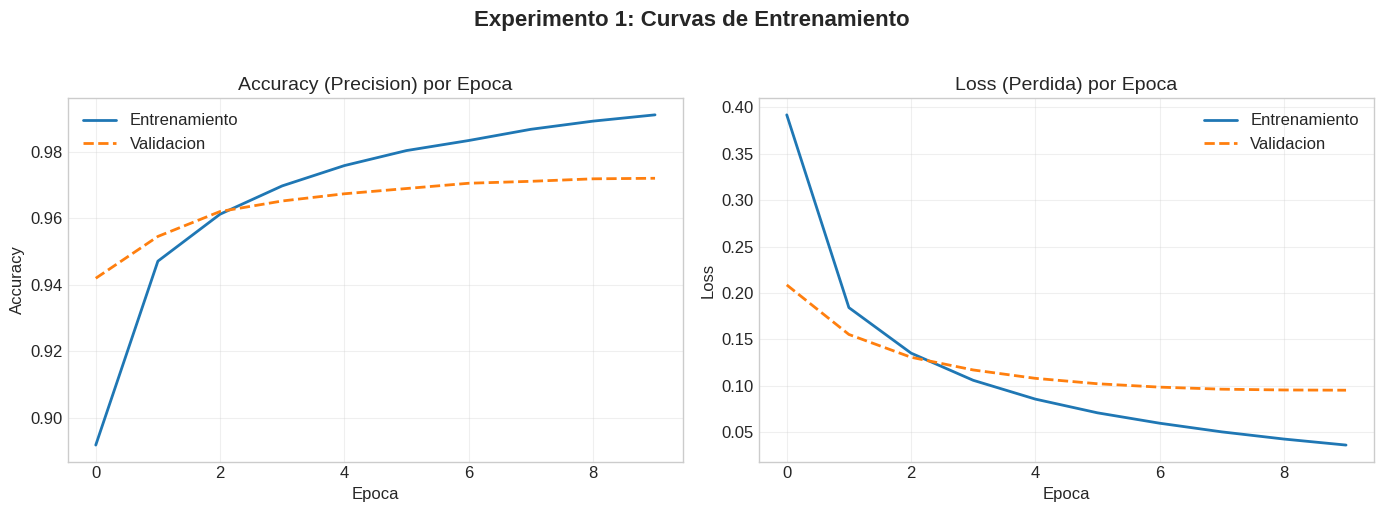

In [13]:
# --- Paso 5: Graficar las curvas de entrenamiento ---
# Estas curvas son FUNDAMENTALES para diagnosticar el comportamiento del modelo.

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafica de Accuracy
axes[0].plot(historial_1.history['accuracy'], label='Entrenamiento', linewidth=2)
axes[0].plot(historial_1.history['val_accuracy'], label='Validacion', linewidth=2, linestyle='--')
axes[0].set_title('Accuracy (Precision) por Epoca', fontsize=14)
axes[0].set_xlabel('Epoca')
axes[0].set_ylabel('Accuracy')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# Grafica de Loss
axes[1].plot(historial_1.history['loss'], label='Entrenamiento', linewidth=2)
axes[1].plot(historial_1.history['val_loss'], label='Validacion', linewidth=2, linestyle='--')
axes[1].set_title('Loss (Perdida) por Epoca', fontsize=14)
axes[1].set_xlabel('Epoca')
axes[1].set_ylabel('Loss')
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Experimento 1: Curvas de Entrenamiento', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [14]:
# --- Paso 6: Evaluar en el conjunto de prueba ---
# IMPORTANTE: El conjunto de prueba NUNCA se usa durante el entrenamiento.
# Es la medida final y objetiva del rendimiento del modelo.

loss_test, accuracy_test = modelo_1.evaluate(x_test, y_test, verbose=0)

print("="*60)
print("RESULTADOS EN EL CONJUNTO DE PRUEBA")
print("="*60)
print(f"  Loss (perdida):     {loss_test:.4f}")
print(f"  Accuracy (precision): {accuracy_test:.4f}  ({accuracy_test*100:.2f}%)")
print("="*60)
print(f"\nTu primera red neuronal clasifica correctamente el {accuracy_test*100:.2f}% de los digitos!")

RESULTADOS EN EL CONJUNTO DE PRUEBA
  Loss (perdida):     0.0828
  Accuracy (precision): 0.9752  (97.52%)

Tu primera red neuronal clasifica correctamente el 97.52% de los digitos!


### \u270d\ufe0f Tu respuesta - Experimento 1:

**Pregunta:** ?Que accuracy obtuviste en el set de prueba? ?Como se comparan las curvas de entrenamiento vs validacion? ?Hay indicios de overfitting?

* 97%
* ambas estan mu cercanas al 100% de precicion
* no hay inicios de overitting? no porque el entrenamiento y la validacion son muy similares y se entiende que un valor tan alto de Accuracy por el dataset


---

### Experimento 2: Efecto del Numero de Capas Ocultas

Ahora vamos a investigar una pregunta clave: **?agregar mas capas mejora el modelo?**

Compararemos tres arquitecturas:

| Modelo | Capas Ocultas | Neuronas |
|:------:|:-------------:|:--------:|
| A | 1 capa | 128 |
| B | 2 capas | 128, 64 |
| C | 3 capas | 256, 128, 64 |

Para hacer una comparacion justa, usaremos los mismos hiperparametros (optimizador, epochs, batch_size) en los tres modelos.

In [15]:
# ============================================================
# EXPERIMENTO 2: Efecto del numero de capas ocultas
# ============================================================

# Funcion auxiliar para crear, compilar, entrenar y evaluar un modelo.
# Esto evita repetir codigo y nos permite experimentar facilmente.

def crear_y_entrenar_modelo(capas_ocultas, nombre, epochs=10, verbose=0):
    """
    Crea, compila, entrena y evalua un modelo con la configuracion dada.

    Parametros:
    - capas_ocultas: lista de tuplas (neuronas, activacion) para cada capa oculta
    - nombre: nombre del modelo
    - epochs: numero de epocas de entrenamiento
    - verbose: nivel de detalle de la salida

    Retorna:
    - modelo entrenado, historial de entrenamiento, tiempo de entrenamiento
    """
    # Crear modelo
    modelo = keras.Sequential(name=nombre)

    # Primera capa oculta (necesita input_shape)
    modelo.add(layers.Dense(capas_ocultas[0], activation='relu', input_shape=(784,)))

    # Capas ocultas adicionales
    for neuronas in capas_ocultas[1:]:
        modelo.add(layers.Dense(neuronas, activation='relu'))

    # Capa de salida
    modelo.add(layers.Dense(10, activation='softmax'))

    # Compilar
    modelo.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Entrenar y medir tiempo
    inicio = time.time()
    historial = modelo.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=128,
        validation_split=0.2,
        verbose=verbose
    )
    tiempo = time.time() - inicio

    return modelo, historial, tiempo

print("Funcion auxiliar definida correctamente.")

Funcion auxiliar definida correctamente.


In [16]:
# Entrenar los tres modelos
print("Entrenando Modelo A (1 capa oculta: 128)...")
modelo_A, hist_A, tiempo_A = crear_y_entrenar_modelo([128], 'Modelo_A_1capa')
print(f"  Completado en {tiempo_A:.1f}s")

print("\nEntrenando Modelo B (2 capas ocultas: 128, 64)...")
modelo_B, hist_B, tiempo_B = crear_y_entrenar_modelo([128, 64], 'Modelo_B_2capas')
print(f"  Completado en {tiempo_B:.1f}s")

print("\nEntrenando Modelo C (3 capas ocultas: 256, 128, 64)...")
modelo_C, hist_C, tiempo_C = crear_y_entrenar_modelo([256, 128, 64], 'Modelo_C_3capas')
print(f"  Completado en {tiempo_C:.1f}s")

print("\nTodos los modelos entrenados!")

Entrenando Modelo A (1 capa oculta: 128)...
  Completado en 13.3s

Entrenando Modelo B (2 capas ocultas: 128, 64)...
  Completado en 14.3s

Entrenando Modelo C (3 capas ocultas: 256, 128, 64)...
  Completado en 15.3s

Todos los modelos entrenados!


In [17]:
# Evaluar los tres modelos en el conjunto de prueba
loss_A, acc_A = modelo_A.evaluate(x_test, y_test, verbose=0)
loss_B, acc_B = modelo_B.evaluate(x_test, y_test, verbose=0)
loss_C, acc_C = modelo_C.evaluate(x_test, y_test, verbose=0)

# Mostrar tabla comparativa
print("="*75)
print("COMPARACION DE MODELOS - Experimento 2")
print("="*75)
print(f"{'Modelo':<25} {'Capas':<15} {'Params':<12} {'Accuracy':<12} {'Loss':<10} {'Tiempo':<10}")
print("-"*75)
print(f"{'A (1 capa: 128)':<25} {'1':<15} {modelo_A.count_params():<12,} {acc_A:<12.4f} {loss_A:<10.4f} {tiempo_A:<10.1f}s")
print(f"{'B (2 capas: 128,64)':<25} {'2':<15} {modelo_B.count_params():<12,} {acc_B:<12.4f} {loss_B:<10.4f} {tiempo_B:<10.1f}s")
print(f"{'C (3 capas: 256,128,64)':<25} {'3':<15} {modelo_C.count_params():<12,} {acc_C:<12.4f} {loss_C:<10.4f} {tiempo_C:<10.1f}s")
print("="*75)

COMPARACION DE MODELOS - Experimento 2
Modelo                    Capas           Params       Accuracy     Loss       Tiempo    
---------------------------------------------------------------------------
A (1 capa: 128)           1               101,770      0.9753       0.0805     13.3      s
B (2 capas: 128,64)       2               109,386      0.9718       0.1060     14.3      s
C (3 capas: 256,128,64)   3               242,762      0.9794       0.0866     15.3      s


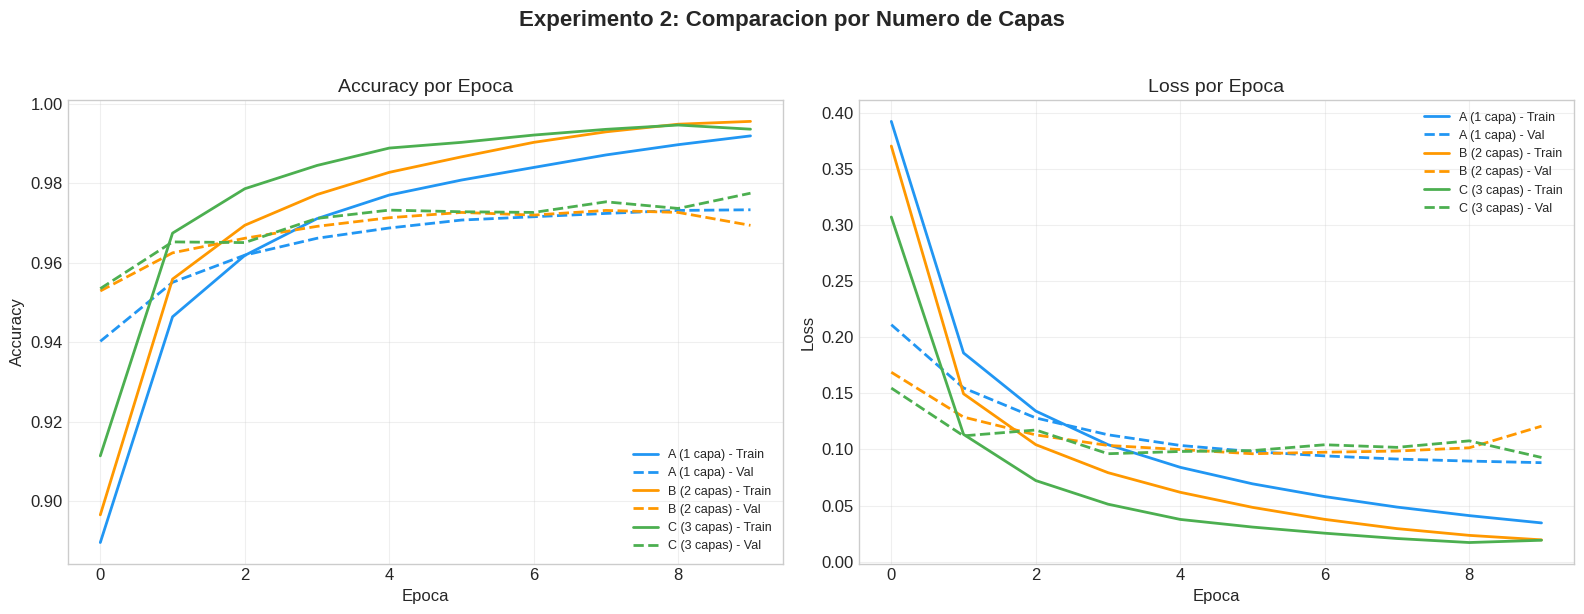

In [18]:
# Graficar las curvas de entrenamiento de los tres modelos superpuestas
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colores = ['#2196F3', '#FF9800', '#4CAF50']  # Azul, Naranja, Verde
nombres = ['A (1 capa)', 'B (2 capas)', 'C (3 capas)']
historiales = [hist_A, hist_B, hist_C]

for i, (hist, nombre, color) in enumerate(zip(historiales, nombres, colores)):
    # Accuracy
    axes[0].plot(hist.history['accuracy'], label=f'{nombre} - Train', color=color, linewidth=2)
    axes[0].plot(hist.history['val_accuracy'], label=f'{nombre} - Val', color=color, linewidth=2, linestyle='--')

    # Loss
    axes[1].plot(hist.history['loss'], label=f'{nombre} - Train', color=color, linewidth=2)
    axes[1].plot(hist.history['val_loss'], label=f'{nombre} - Val', color=color, linewidth=2, linestyle='--')

axes[0].set_title('Accuracy por Epoca', fontsize=14)
axes[0].set_xlabel('Epoca')
axes[0].set_ylabel('Accuracy')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Loss por Epoca', fontsize=14)
axes[1].set_xlabel('Epoca')
axes[1].set_ylabel('Loss')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Experimento 2: Comparacion por Numero de Capas', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### \u270d\ufe0f Tu respuesta - Experimento 2:

**Pregunta:** ?Agregar mas capas siempre mejora el resultado? ?Que observaste con el tiempo de entrenamiento? ?Cual modelo tiene mejor relacion rendimiento/complejidad?

* No siempre, es incluso muy minimo el cambio
* son muy similares
* el de dos capas precenta un tiempo con muy poca diferencia de los demas y resultados mas acertados



---

### Experimento 3: Efecto del Numero de Neuronas por Capa

Ahora mantendremos fija la estructura (2 capas ocultas) y variaremos la **cantidad de neuronas**. Esto nos permitira entender la relacion entre la amplitud de la red y su capacidad de aprendizaje.

| Modelo | Capa 1 | Capa 2 | Total aproximado de parametros |
|:------:|:------:|:------:|:------------------------------:|
| Pequeno | 32 | 16 | ~25,000 |
| Mediano | 64 | 32 | ~52,000 |
| Grande | 128 | 64 | ~110,000 |
| Muy Grande | 512 | 256 | ~530,000 |

In [19]:
# ============================================================
# EXPERIMENTO 3: Efecto del numero de neuronas por capa
# ============================================================

configuraciones = [
    ([32, 16], 'Pequeno_32_16'),
    ([64, 32], 'Mediano_64_32'),
    ([128, 64], 'Grande_128_64'),
    ([512, 256], 'MuyGrande_512_256')
]

resultados_exp3 = []

for config, nombre in configuraciones:
    print(f"Entrenando modelo {nombre}...")
    modelo, hist, tiempo = crear_y_entrenar_modelo(config, nombre)
    loss, acc = modelo.evaluate(x_test, y_test, verbose=0)
    params = modelo.count_params()
    resultados_exp3.append({
        'nombre': nombre,
        'config': config,
        'accuracy': acc,
        'loss': loss,
        'params': params,
        'tiempo': tiempo,
        'historial': hist
    })
    print(f"  Accuracy: {acc:.4f} | Params: {params:,} | Tiempo: {tiempo:.1f}s")

print("\nTodos los modelos entrenados!")

Entrenando modelo Pequeno_32_16...
  Accuracy: 0.9582 | Params: 25,818 | Tiempo: 14.4s
Entrenando modelo Mediano_64_32...
  Accuracy: 0.9682 | Params: 52,650 | Tiempo: 14.9s
Entrenando modelo Grande_128_64...
  Accuracy: 0.9763 | Params: 109,386 | Tiempo: 15.2s
Entrenando modelo MuyGrande_512_256...
  Accuracy: 0.9790 | Params: 535,818 | Tiempo: 17.0s

Todos los modelos entrenados!


In [20]:
# Tabla comparativa del Experimento 3
print("="*80)
print("COMPARACION DE MODELOS - Experimento 3: Numero de Neuronas")
print("="*80)
print(f"{'Modelo':<25} {'Neuronas':<15} {'Parametros':<15} {'Accuracy':<12} {'Tiempo':<10}")
print("-"*80)
for r in resultados_exp3:
    print(f"{r['nombre']:<25} {str(r['config']):<15} {r['params']:<15,} {r['accuracy']:<12.4f} {r['tiempo']:<10.1f}s")
print("="*80)

COMPARACION DE MODELOS - Experimento 3: Numero de Neuronas
Modelo                    Neuronas        Parametros      Accuracy     Tiempo    
--------------------------------------------------------------------------------
Pequeno_32_16             [32, 16]        25,818          0.9582       14.4      s
Mediano_64_32             [64, 32]        52,650          0.9682       14.9      s
Grande_128_64             [128, 64]       109,386         0.9763       15.2      s
MuyGrande_512_256         [512, 256]      535,818         0.9790       17.0      s


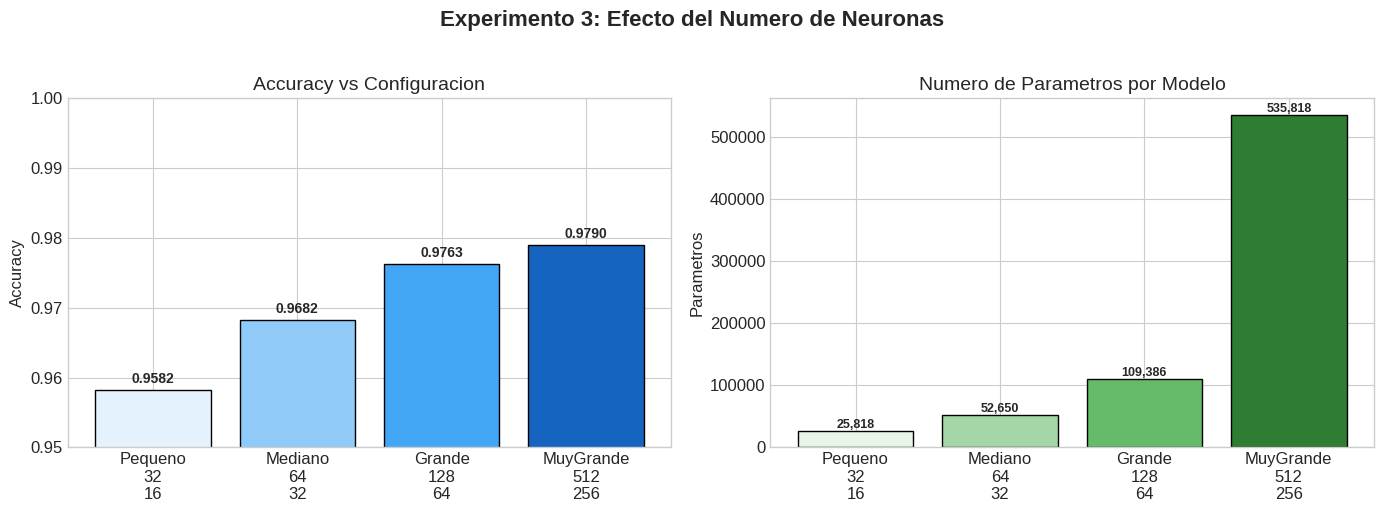

In [21]:
# Visualizacion: Accuracy vs Numero de parametros
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

params_list = [r['params'] for r in resultados_exp3]
acc_list = [r['accuracy'] for r in resultados_exp3]
tiempo_list = [r['tiempo'] for r in resultados_exp3]
nombres_list = [r['nombre'].replace('_', '\n') for r in resultados_exp3]

# Accuracy vs Parametros
axes[0].bar(nombres_list, acc_list, color=['#E3F2FD', '#90CAF9', '#42A5F5', '#1565C0'], edgecolor='black')
axes[0].set_title('Accuracy vs Configuracion', fontsize=14)
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0.95, 1.0)
for i, (nombre, acc) in enumerate(zip(nombres_list, acc_list)):
    axes[0].text(i, acc + 0.001, f'{acc:.4f}', ha='center', fontsize=10, fontweight='bold')

# Parametros vs Tiempo
axes[1].bar(nombres_list, params_list, color=['#E8F5E9', '#A5D6A7', '#66BB6A', '#2E7D32'], edgecolor='black')
axes[1].set_title('Numero de Parametros por Modelo', fontsize=14)
axes[1].set_ylabel('Parametros')
for i, (nombre, p) in enumerate(zip(nombres_list, params_list)):
    axes[1].text(i, p + 5000, f'{p:,}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('Experimento 3: Efecto del Numero de Neuronas', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### \u270d\ufe0f Tu respuesta - Experimento 3:

**Pregunta:** ?Cual es la relacion entre el numero de neuronas y el rendimiento? ?Y con el numero de parametros? (Observa los valores de `model.count_params()` en la tabla). ?Tiene sentido usar siempre el modelo mas grande?

* a mas neuronas tiende a aprender mas
* segun parece ser la opcion mas vialble



---

### Experimento 4: Efecto del Numero de Epocas

Una **epoca** es una pasada completa por todo el dataset de entrenamiento. Mas epocas significa que el modelo ve los datos mas veces. Pero, ?mas siempre es mejor?

Vamos a entrenar el mismo modelo con diferentes cantidades de epocas y observar cuando el modelo **deja de mejorar** o incluso empieza a **empeorar** (overfitting).

In [22]:
# ============================================================
# EXPERIMENTO 4: Efecto del numero de epocas
# ============================================================

# Entrenaremos un unico modelo por 50 epocas y analizaremos
# el comportamiento en distintos puntos.

print("Entrenando modelo con 50 epocas (esto puede tardar un poco)...")
print("="*60)

modelo_epocas = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(784,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
], name='Modelo_Epocas')

modelo_epocas.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

historial_epocas = modelo_epocas.fit(
    x_train, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

print("\nEntrenamiento completado!")

Entrenando modelo con 50 epocas (esto puede tardar un poco)...
Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8147 - loss: 0.6505 - val_accuracy: 0.9501 - val_loss: 0.1762
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9512 - loss: 0.1642 - val_accuracy: 0.9620 - val_loss: 0.1283
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9670 - loss: 0.1111 - val_accuracy: 0.9673 - val_loss: 0.1088
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9753 - loss: 0.0820 - val_accuracy: 0.9699 - val_loss: 0.1007
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9823 - loss: 0.0628 - val_accuracy: 0.9722 - val_loss: 0.0939
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9867 - loss: 0.0490 - val_accuracy: 0.9735 - val_loss: 0.0914
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9902 - loss: 0.0378 - val_accuracy: 0.9737 - val_loss: 0.0945
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1

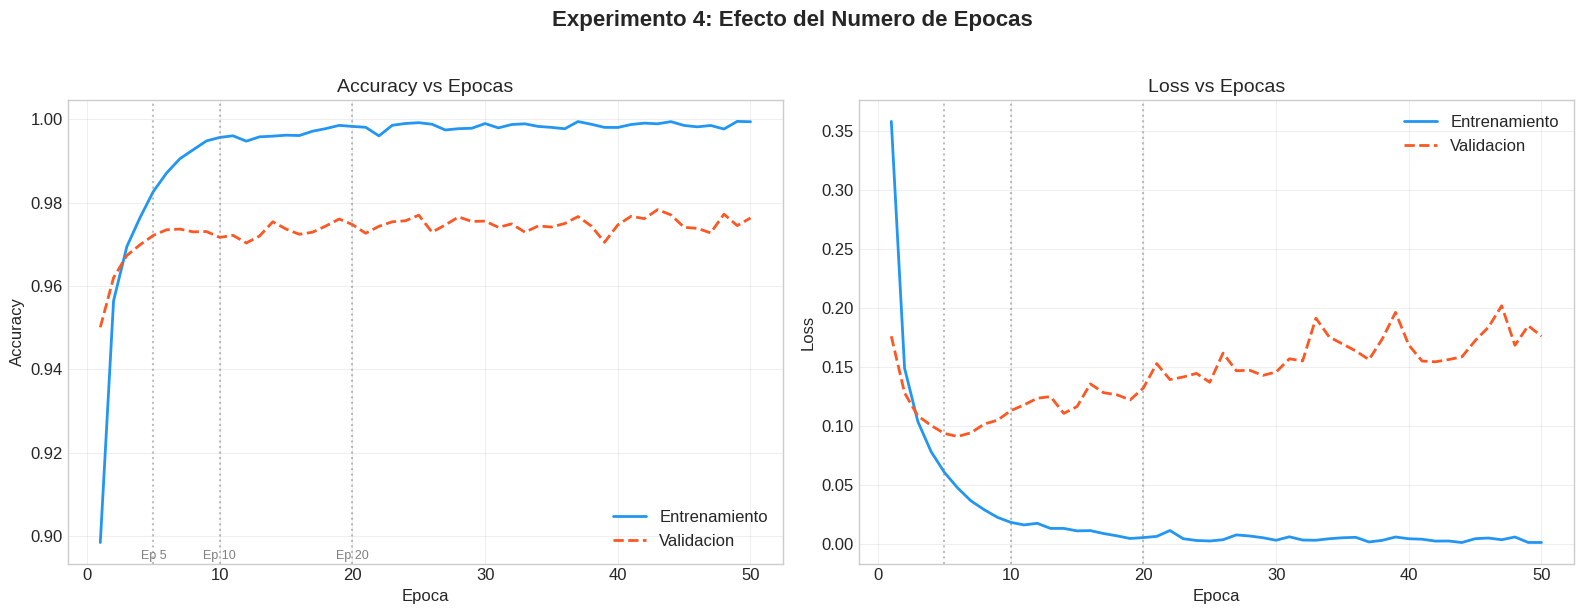

In [23]:
# Graficar el comportamiento a lo largo de las 50 epocas
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

epocas = range(1, 51)

# Accuracy
axes[0].plot(epocas, historial_epocas.history['accuracy'], label='Entrenamiento', linewidth=2, color='#2196F3')
axes[0].plot(epocas, historial_epocas.history['val_accuracy'], label='Validacion', linewidth=2, color='#FF5722', linestyle='--')
axes[0].set_title('Accuracy vs Epocas', fontsize=14)
axes[0].set_xlabel('Epoca')
axes[0].set_ylabel('Accuracy')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# Marcar puntos de referencia en las epocas 5, 10, 20
for ep in [5, 10, 20]:
    axes[0].axvline(x=ep, color='gray', linestyle=':', alpha=0.5)
    axes[0].text(ep, axes[0].get_ylim()[0] + 0.001, f'Ep {ep}', ha='center', fontsize=9, color='gray')

# Loss
axes[1].plot(epocas, historial_epocas.history['loss'], label='Entrenamiento', linewidth=2, color='#2196F3')
axes[1].plot(epocas, historial_epocas.history['val_loss'], label='Validacion', linewidth=2, color='#FF5722', linestyle='--')
axes[1].set_title('Loss vs Epocas', fontsize=14)
axes[1].set_xlabel('Epoca')
axes[1].set_ylabel('Loss')
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

for ep in [5, 10, 20]:
    axes[1].axvline(x=ep, color='gray', linestyle=':', alpha=0.5)

plt.suptitle('Experimento 4: Efecto del Numero de Epocas', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [24]:
# Mostrar accuracy y loss en puntos clave
print("="*70)
print("RENDIMIENTO EN DIFERENTES EPOCAS")
print("="*70)
print(f"{'Epoca':<10} {'Train Acc':<15} {'Val Acc':<15} {'Train Loss':<15} {'Val Loss':<15}")
print("-"*70)

for ep in [4, 9, 19, 49]:  # Indices 0-based para epocas 5, 10, 20, 50
    t_acc = historial_epocas.history['accuracy'][ep]
    v_acc = historial_epocas.history['val_accuracy'][ep]
    t_loss = historial_epocas.history['loss'][ep]
    v_loss = historial_epocas.history['val_loss'][ep]
    print(f"{ep+1:<10} {t_acc:<15.4f} {v_acc:<15.4f} {t_loss:<15.4f} {v_loss:<15.4f}")

print("="*70)

# Detectar posible overfitting
# Overfitting: train_acc sube pero val_acc se estanca o baja
#              train_loss baja pero val_loss sube
val_losses = historial_epocas.history['val_loss']
mejor_epoca = np.argmin(val_losses) + 1
print(f"\nMejor epoca segun val_loss: Epoca {mejor_epoca}")
print(f"Val Loss en epoca {mejor_epoca}: {val_losses[mejor_epoca-1]:.4f}")
print(f"Val Loss en epoca 50: {val_losses[-1]:.4f}")

if val_losses[-1] > val_losses[mejor_epoca-1] * 1.05:
    print("\n** ALERTA: Se detecta posible overfitting. **")
    print("La perdida de validacion aumento despues de su mejor punto.")
else:
    print("\nNo se detecta overfitting significativo.")

RENDIMIENTO EN DIFERENTES EPOCAS
Epoca      Train Acc       Val Acc         Train Loss      Val Loss       
----------------------------------------------------------------------
5          0.9827          0.9722          0.0611          0.0939         
10         0.9957          0.9717          0.0187          0.1133         
20         0.9983          0.9747          0.0059          0.1325         
50         0.9994          0.9763          0.0017          0.1763         

Mejor epoca segun val_loss: Epoca 6
Val Loss en epoca 6: 0.0914
Val Loss en epoca 50: 0.1763

** ALERTA: Se detecta posible overfitting. **
La perdida de validacion aumento despues de su mejor punto.


### \u270d\ufe0f Tu respuesta - Experimento 4:

**Pregunta:** ?A partir de cuantas epocas el modelo deja de mejorar significativamente? ?Observas overfitting con muchas epocas? ?Como lo sabes? (Pista: observa la diferencia entre las curvas de entrenamiento y validacion).

* Segun parece de la sexta en adelante tiende a empeorar
* Seguramente si tiene Overfetting por que en laws epocas se muestra que el modelo esta memorizando en lugar de aprender



---

### Experimento 5: Visualizando Predicciones y Matriz de Confusion

Los numeros son utiles, pero **ver** lo que el modelo predice nos da una comprension mucho mas profunda de su comportamiento. Vamos a:

1. Visualizar predicciones individuales
2. Construir una matriz de confusion para ver donde se equivoca sistematicamente

In [25]:
# ============================================================
# EXPERIMENTO 5: Visualizacion de predicciones
# ============================================================

# Usaremos el mejor modelo del Experimento 2 (modelo_B con 2 capas)
# para hacer predicciones sobre el conjunto de prueba.

# Obtener predicciones
predicciones = modelo_B.predict(x_test, verbose=0)

# predicciones tiene forma (10000, 10): 10 probabilidades por imagen
# Tomamos la clase con mayor probabilidad
clases_predichas = np.argmax(predicciones, axis=1)
clases_reales = y_test_raw  # Las etiquetas originales (no one-hot)

print(f"Forma de las predicciones: {predicciones.shape}")
print(f"\nEjemplo de prediccion para la primera imagen:")
print(f"  Probabilidades: {np.round(predicciones[0], 4)}")
print(f"  Clase predicha: {clases_predichas[0]}")
print(f"  Clase real:     {clases_reales[0]}")

Forma de las predicciones: (10000, 10)

Ejemplo de prediccion para la primera imagen:
  Probabilidades: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  Clase predicha: 7
  Clase real:     7


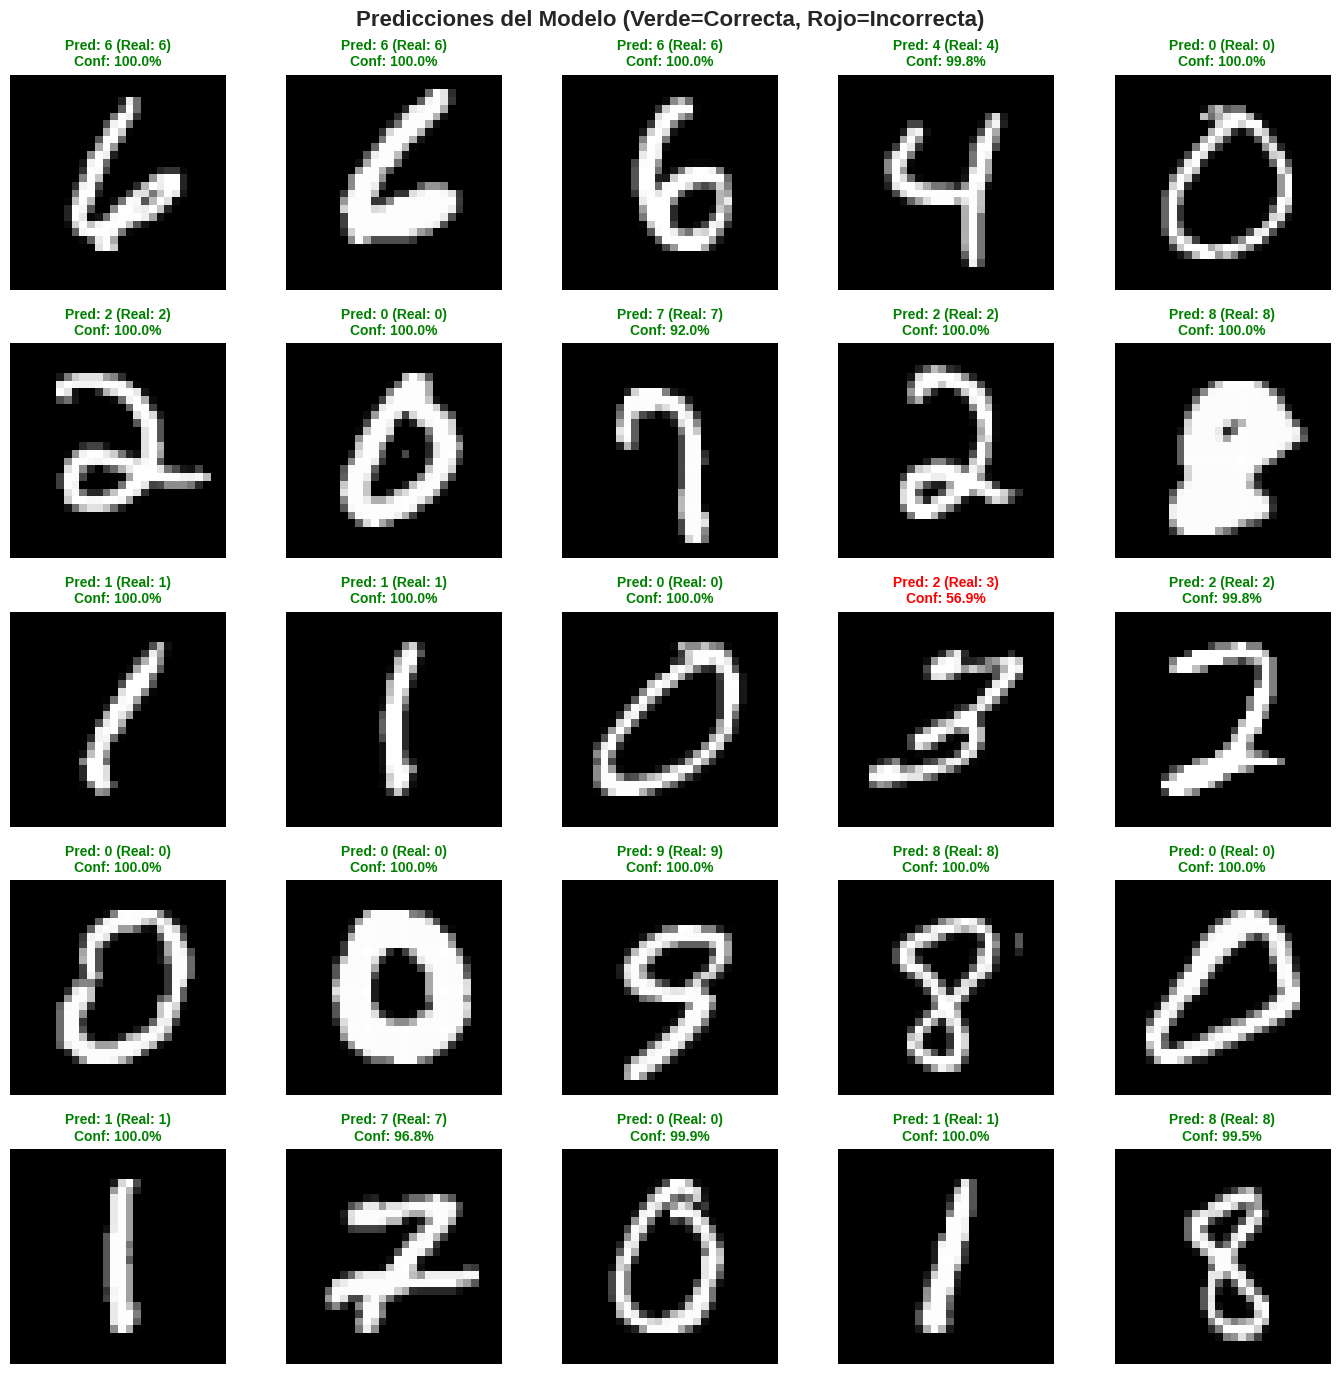

In [26]:
# --- Visualizar 25 predicciones ---
# Verde = prediccion correcta, Rojo = prediccion incorrecta

fig, axes = plt.subplots(5, 5, figsize=(14, 14))
fig.suptitle('Predicciones del Modelo (Verde=Correcta, Rojo=Incorrecta)',
             fontsize=16, fontweight='bold')

# Seleccionar 25 indices aleatorios
indices = np.random.choice(len(x_test), 25, replace=False)

for i, ax in enumerate(axes.flat):
    idx = indices[i]
    imagen = x_test_raw[idx]  # Imagen original sin normalizar para visualizacion
    pred = clases_predichas[idx]
    real = clases_reales[idx]
    confianza = predicciones[idx][pred] * 100  # Probabilidad de la prediccion

    ax.imshow(imagen, cmap='gray')

    # Color del titulo segun si es correcta o no
    if pred == real:
        color = 'green'
        titulo = f'Pred: {pred} (Real: {real})\nConf: {confianza:.1f}%'
    else:
        color = 'red'
        titulo = f'Pred: {pred} (Real: {real})\nConf: {confianza:.1f}%'

    ax.set_title(titulo, fontsize=10, color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

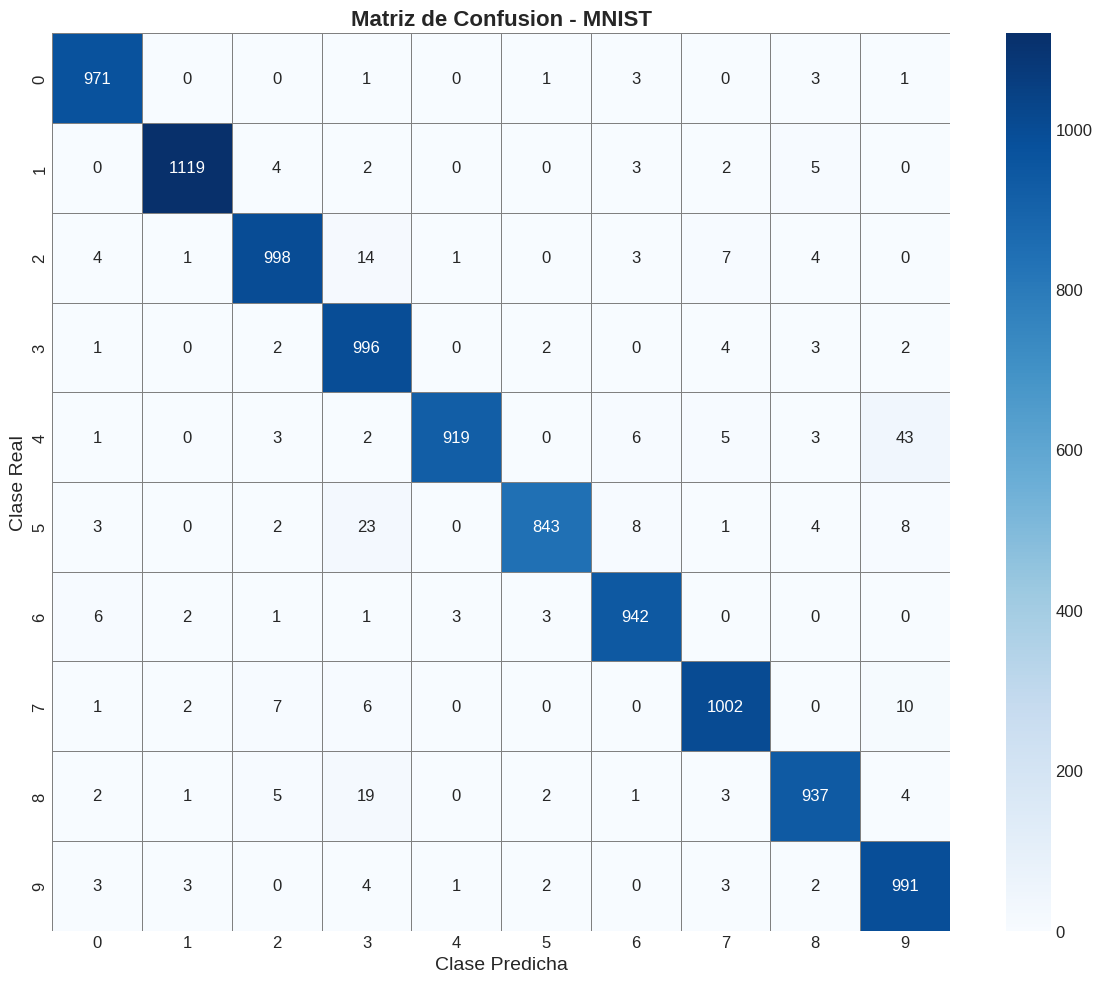

In [27]:
# --- Matriz de Confusion ---
# La matriz de confusion muestra cuantas veces cada clase fue predicha
# como cada otra clase. Es una herramienta fundamental para entender
# los errores del modelo.

cm = confusion_matrix(clases_reales, clases_predichas)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10),
            linewidths=0.5, linecolor='gray')
plt.title('Matriz de Confusion - MNIST', fontsize=16, fontweight='bold')
plt.xlabel('Clase Predicha', fontsize=14)
plt.ylabel('Clase Real', fontsize=14)
plt.tight_layout()
plt.show()

# Interpretacion:
# - Los valores en la diagonal son las predicciones correctas
# - Los valores fuera de la diagonal son los errores
# - Fila i, Columna j: cuantas veces el digito i fue predicho como j

In [28]:
# --- Reporte de clasificacion ---
# Muestra precision, recall y f1-score por cada clase

print("="*60)
print("REPORTE DE CLASIFICACION DETALLADO")
print("="*60)
print(classification_report(clases_reales, clases_predichas,
                            target_names=[f'Digito {i}' for i in range(10)]))

REPORTE DE CLASIFICACION DETALLADO
              precision    recall  f1-score   support

    Digito 0       0.98      0.99      0.98       980
    Digito 1       0.99      0.99      0.99      1135
    Digito 2       0.98      0.97      0.97      1032
    Digito 3       0.93      0.99      0.96      1010
    Digito 4       0.99      0.94      0.96       982
    Digito 5       0.99      0.95      0.97       892
    Digito 6       0.98      0.98      0.98       958
    Digito 7       0.98      0.97      0.98      1028
    Digito 8       0.98      0.96      0.97       974
    Digito 9       0.94      0.98      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [29]:
# --- Encontrar los errores mas comunes ---
# Veamos cuales son las confusiones mas frecuentes

# Poner la diagonal en 0 para ver solo errores
cm_errores = cm.copy()
np.fill_diagonal(cm_errores, 0)

# Encontrar las 5 confusiones mas comunes
print("\nTOP 5 CONFUSIONES MAS FRECUENTES:")
print("-"*40)
for _ in range(5):
    i, j = np.unravel_index(cm_errores.argmax(), cm_errores.shape)
    print(f"  Digito {i} confundido con {j}: {cm_errores[i, j]} veces")
    cm_errores[i, j] = 0  # Poner en 0 para encontrar el siguiente


TOP 5 CONFUSIONES MAS FRECUENTES:
----------------------------------------
  Digito 4 confundido con 9: 43 veces
  Digito 5 confundido con 3: 23 veces
  Digito 8 confundido con 3: 19 veces
  Digito 2 confundido con 3: 14 veces
  Digito 7 confundido con 9: 10 veces


### \u270d\ufe0f Tu respuesta - Experimento 5:

**Pregunta:** ?Que digitos confunde mas el modelo entre si? ?Tiene sentido que esos digitos se confundan? ?Por que? (Piensa en como lucen visualmente esos digitos.)

* el 4 con el 9 es el mas confundio entre si
* Seguranete por la manera en que se puede dibujar el 4 y un 9 con el palo derecho, lo que hace que se asemejen (Yo de pequeño LOL)



---

### Experimento 6: API Functional de Keras (Introduccion)

Hasta ahora hemos usado la **API Sequential**, que apila capas una tras otra como una torre de bloques. Pero Keras tambien ofrece la **API Functional**, que es mas flexible y permite crear arquitecturas mas complejas.

**?Cuando usar cada una?**

- **Sequential:** Cuando tu modelo es una secuencia lineal de capas (la salida de una es la entrada de la siguiente). Perfecto para empezar.
- **Functional:** Cuando necesitas:
  - Multiples entradas o salidas
  - Conexiones residuales (skip connections)
  - Arquitecturas en paralelo (como redes siamesas)
  - Compartir capas entre diferentes partes del modelo

Vamos a reconstruir nuestro mejor modelo usando la API Functional para entender la diferencia en sintaxis.

In [30]:
# ============================================================
# EXPERIMENTO 6: API Functional de Keras
# ============================================================

# --- API Sequential (lo que ya conocemos) ---
# modelo_seq = keras.Sequential([
#     layers.Dense(128, activation='relu', input_shape=(784,)),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(10, activation='softmax')
# ])

# --- API Functional (nueva forma) ---
# En la API Functional, definimos cada capa como una funcion
# que toma como entrada la salida de la capa anterior.

# Paso 1: Definir la entrada
entrada = keras.Input(shape=(784,), name='entrada')

# Paso 2: Definir las capas ocultas como funciones
# Nota: cada capa recibe la salida de la anterior como argumento
x = layers.Dense(128, activation='relu', name='capa_oculta_1')(entrada)
x = layers.Dense(64, activation='relu', name='capa_oculta_2')(x)

# Paso 3: Definir la capa de salida
salida = layers.Dense(10, activation='softmax', name='capa_salida')(x)

# Paso 4: Crear el modelo especificando entrada y salida
modelo_functional = keras.Model(inputs=entrada, outputs=salida, name='Modelo_Functional')

# Ver el resumen
modelo_functional.summary()

print("\nEl modelo se ve identico al Sequential, pero la API Functional")
print("permite crear arquitecturas mucho mas complejas en el futuro.")

Model: "Modelo_Functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ entrada (InputLayer)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_1 (Dense)           │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_2 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_salida (Dense)             │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)


El modelo se ve identico al Sequential, pero la API Functional
permite crear arquitecturas mucho mas complejas en el futuro.


In [31]:
# Compilar y entrenar el modelo Functional
modelo_functional.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Entrenando modelo con API Functional...")
historial_func = modelo_functional.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

# Evaluar
loss_func, acc_func = modelo_functional.evaluate(x_test, y_test, verbose=0)
print(f"\nAccuracy en test: {acc_func:.4f} ({acc_func*100:.2f}%)")
print("\nEl resultado es similar al modelo Sequential, como esperabamos.")
print("La diferencia esta en la flexibilidad, no en el rendimiento.")

Entrenando modelo con API Functional...
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8071 - loss: 0.6989 - val_accuracy: 0.9503 - val_loss: 0.1758
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9515 - loss: 0.1632 - val_accuracy: 0.9628 - val_loss: 0.1257
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9685 - loss: 0.1066 - val_accuracy: 0.9666 - val_loss: 0.1104
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9767 - loss: 0.0793 - val_accuracy: 0.9699 - val_loss: 0.1008
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9821 - loss: 0.0608 - val_accuracy: 0.9721 - val_loss: 0.0950
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9872 - loss: 0.0462 - val_accuracy: 0.9718 - val_loss: 0.0962
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9909 - loss: 0.0354 - val_accuracy: 0.9714 - val_loss: 0.0970
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 

In [32]:
# --- Ejemplo avanzado: Modelo con multiples salidas (solo demostrativo) ---
# Este ejemplo muestra por que la API Functional es poderosa.
# Imaginemos que queremos predecir:
#   1. El digito (0-9)
#   2. Si el digito es par o impar (binario)

# Con Sequential esto NO es posible. Con Functional SI:

entrada_demo = keras.Input(shape=(784,), name='entrada_demo')
x_demo = layers.Dense(128, activation='relu', name='compartida_1')(entrada_demo)
x_demo = layers.Dense(64, activation='relu', name='compartida_2')(x_demo)

# Salida 1: Clasificacion del digito (10 clases)
salida_digito = layers.Dense(10, activation='softmax', name='salida_digito')(x_demo)

# Salida 2: Par o impar (2 clases)
salida_paridad = layers.Dense(2, activation='softmax', name='salida_paridad')(x_demo)

modelo_multi = keras.Model(
    inputs=entrada_demo,
    outputs=[salida_digito, salida_paridad],
    name='Modelo_MultiSalida'
)

modelo_multi.summary()

print("\nEste modelo tiene DOS salidas! Esto es imposible con Sequential.")
print("En guias futuras veremos arquitecturas mas complejas usando la API Functional.")

Model: "Modelo_MultiSalida"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ entrada_demo        │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ compartida_1        │ (None, 128)       │    100,480 │ entrada_demo[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ compartida_2        │ (None, 64)        │      8,256 │ compartida_1[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ salida_digito       │ (None, 10)        │        650 │ compartida_2[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ salida_paridad      │ (None, 2)         │        130 │ compartida_2[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 109,516 (427.80 KB)

 Trainable params: 109,516 (427.80 KB)

 Non-trainable params: 0 (0.00 B)


Este modelo tiene DOS salidas! Esto es imposible con Sequential.
En guias futuras veremos arquitecturas mas complejas usando la API Functional.


### \u270d\ufe0f Tu respuesta - Experimento 6:

**Pregunta:** ?Que ventajas tiene la API Functional sobre la Sequential? ?En que casos usarias cada una?

* Secuentials no puede tener dos salidas se diferencia mas en la flexibilidad que en el rendimiento

* Secuentials es mas simple y se debe usar para casos mas sencillos y de una sola salida o de capas lineales



---

## 5. Sintesis y Reflexion Final

Has completado una serie de experimentos fundamentales sobre redes neuronales. Ahora es momento de sintetizar lo que aprendiste.

---

### \u270d\ufe0f Pregunta de Sintesis 1:

**?Cuales son los hiperparametros mas importantes que observaste al construir una red neuronal?** Menciona al menos 4 y explica como afecta cada uno al rendimiento.

* Numero de capas: Mediante el aumento de caps, se pueden legar a resultados mas especificos o exactos, pero estas requeriran mucho mas consumo de recfursos del computador y tiempo invertido.

* Numero de epocas: Cunatas veces el modelo repasa la informacion, a mas epocas se pueden tenr mejores resultados, peero ocurre el risgo de overfetting, o en elcaso contrrio de pocas epocas, el modelo puede no aprender correctamente.

* Neuronas por capa: Puden mejorar los resultados, pero al igual que en las capas aumentar el numero tambien requerira mas recursos y tiempo.

* Batch: Se uso para estabilizar el numero de imagenes que ve el modelo, lo cual puede infliur en la calidad e resultados al aumentar o reducirse en gran medida.



### \u270d\ufe0f Pregunta de Sintesis 2:

**Compara el perceptron de la Guia 01 con la red neuronal de esta guia.** ?Que problema resolvio agregar capas? ?Que diferencias fundamentales hay entre un perceptron simple y un MLP?

* El perceptron se limita a respuestas de si o no, mientras que este modelo MLP puede resolver e indetificar diferencias teniendo en cuenta mas aspectos, esto porque el perceptron solo tiene una capa, pero el MLP puede tener mas,, para poder analizar datos mas comlejos.



### \u270d\ufe0f Pregunta de Sintesis 3:

**Si tuvieras que clasificar imagenes mas complejas (por ejemplo, fotos de objetos reales como perros, gatos, carros), ?crees que esta red (MLP densa) funcionaria bien? ?Por que?** (Pista: piensa en el preprocesamiento que hicimos -- aplanar la imagen a un vector -- y que informacion se pierde.)

* No, esto debido a que MLP es un tanto simple, y no es caps de diferenciar raasgos muy especificos, si es mejor que un perceptron, para el caso de imagenes de animales, se a usado redes convolucionales.



---

## 6. Reto Extra: Fashion-MNIST

Si llegaste hasta aqui y quieres un desafio adicional, prueba tus habilidades con un dataset un poco mas dificil: **Fashion-MNIST**.

Fashion-MNIST tiene la misma estructura que MNIST (60,000 imagenes de 28x28 en escala de grises, 10 clases), pero en lugar de digitos, contiene imagenes de prendas de ropa:

| Clase | Descripcion |
|:-----:|:-----------:|
| 0 | Camiseta/Top |
| 1 | Pantalon |
| 2 | Jersey/Sueter |
| 3 | Vestido |
| 4 | Abrigo |
| 5 | Sandalia |
| 6 | Camisa |
| 7 | Zapatilla deportiva |
| 8 | Bolso |
| 9 | Bota |

### Instrucciones:

1. Carga el dataset con `keras.datasets.fashion_mnist.load_data()`
2. Realiza el mismo preprocesamiento que hicimos con MNIST (normalizar, reshape, one-hot)
3. Disena tu propia arquitectura de red. Tu decides cuantas capas y neuronas usar.
4. Entrena, evalua y muestra la matriz de confusion.
5. **Objetivo:** Alcanzar al menos un **88% de accuracy** en el conjunto de prueba.

### Pistas:
- Fashion-MNIST es mas dificil que MNIST. Los digitos tienen formas mas simples que la ropa.
- Puedes necesitar una red un poco mas grande o mas epocas.
- Presta atencion al overfitting: Fashion-MNIST es mas propenso a ello.
- Experimenta con diferentes configuraciones antes de elegir tu arquitectura final.

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Fashion-MNIST cargado!
Entrenamiento: (60000, 28, 28)
Prueba: (10000, 28, 28)


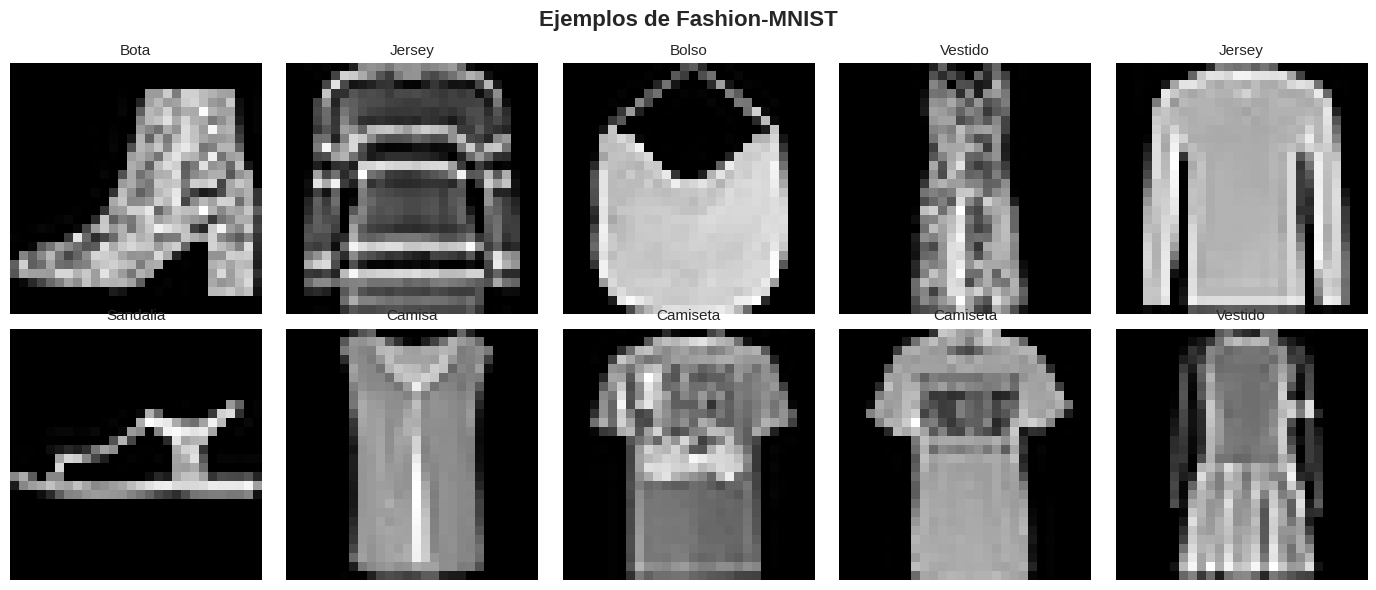

In [33]:
# ============================================================
# RETO EXTRA: Fashion-MNIST
# ============================================================

# Nombres de las clases de Fashion-MNIST (para visualizacion)
nombres_clases_fashion = [
    'Camiseta', 'Pantalon', 'Jersey', 'Vestido', 'Abrigo',
    'Sandalia', 'Camisa', 'Zapatilla', 'Bolso', 'Bota'
]

# --- Paso 1: Cargar los datos ---
(x_train_f, y_train_f), (x_test_f, y_test_f) = keras.datasets.fashion_mnist.load_data()

print(f"Fashion-MNIST cargado!")
print(f"Entrenamiento: {x_train_f.shape}")
print(f"Prueba: {x_test_f.shape}")

# Visualizar algunos ejemplos
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
fig.suptitle('Ejemplos de Fashion-MNIST', fontsize=16, fontweight='bold')
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(x_train_f))
    ax.imshow(x_train_f[idx], cmap='gray')
    ax.set_title(nombres_clases_fashion[y_train_f[idx]], fontsize=11)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [38]:
# --- Paso 2: Preprocesamiento ---
# Escribe tu codigo de preprocesamiento aqui.
# Recuerda: normalizar, reshape y one-hot encoding.

# Tu codigo aqui:
# x_train_fashion = ...
# x_test_fashion = ...
# y_train_fashion = ...
# y_test_fashion = ...



In [39]:
# Normalizar a [0,1]
x_train_fashion = x_train_f / 255.0
x_test_fashion  = x_test_f / 255.0

# Aplanar (28x28 -> 784)
x_train_fashion = x_train_fashion.reshape(-1, 28*28)
x_test_fashion  = x_test_fashion.reshape(-1, 28*28)

# One-hot encoding de las etiquetas
y_train_fashion = keras.utils.to_categorical(y_train_f, 10)
y_test_fashion  = keras.utils.to_categorical(y_test_f, 10)

In [40]:
# --- Paso 3: Disenar tu red neuronal ---
# Crea tu propia arquitectura. Experimenta!
# Objetivo: al menos 88% de accuracy en test.

# Tu codigo aqui:
# modelo_fashion = keras.Sequential([...])



In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

modelo_fashion = Sequential([
    Dense(512, activation='relu', input_shape=(784,)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

modelo_fashion.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# --- Paso 4: Compilar y entrenar ---

# Tu codigo aqui:



In [43]:
modelo_fashion.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

hist_fashion = modelo_fashion.fit(
    x_train_fashion, y_train_fashion,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    verbose=1
)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7091 - loss: 0.7925 - val_accuracy: 0.8428 - val_loss: 0.4257
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8402 - loss: 0.4369 - val_accuracy: 0.8543 - val_loss: 0.3983
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8579 - loss: 0.3921 - val_accuracy: 0.8598 - val_loss: 0.3796
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8640 - loss: 0.3671 - val_accuracy: 0.8707 - val_loss: 0.3525
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8723 - loss: 0.3477 - val_accuracy: 0.8691 - val_loss: 0.3571
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8760 - loss: 0.3311 - val_accuracy: 0.8698 - val_loss: 0.3494
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8790 - loss: 0.3277 - val_accuracy: 0.8798 - val_loss: 0.3335
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8825 - loss: 0.3178 - val_accuracy: 0.

In [37]:
# --- Paso 5: Evaluar y mostrar resultados ---
# Incluye:
#   - Accuracy en test
#   - Curvas de entrenamiento
#   - Matriz de confusion

# Tu codigo aqui:



In [44]:
loss_f, acc_f = modelo_fashion.evaluate(x_test_fashion, y_test_fashion, verbose=0)
print(f"Accuracy: {acc_f:.4f}")

Accuracy: 0.8850


---

## 7. Referencias

### Documentacion oficial
- **TensorFlow/Keras:** [https://www.tensorflow.org/guide/keras](https://www.tensorflow.org/guide/keras)
- **API Sequential:** [https://keras.io/guides/sequential_model/](https://keras.io/guides/sequential_model/)
- **API Functional:** [https://keras.io/guides/functional_api/](https://keras.io/guides/functional_api/)

### Tutoriales recomendados
- **Tutorial oficial de MNIST con Keras:** [https://www.tensorflow.org/tutorials/quickstart/beginner](https://www.tensorflow.org/tutorials/quickstart/beginner)
- **Fashion-MNIST:** [https://www.tensorflow.org/tutorials/keras/classification](https://www.tensorflow.org/tutorials/keras/classification)

### Videos recomendados
- **3Blue1Brown - Neural Networks (serie completa):** [https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
  - Capitulo 1: Que es una red neuronal
  - Capitulo 2: Descenso de gradiente
  - Capitulo 3: Backpropagation

### Lecturas adicionales
- Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning*. MIT Press. Capitulos 6-8.
- LeCun, Y., Cortes, C., & Burges, C. J. (2010). MNIST handwritten digit database.

---

**Proxima guia:** En la Guia 03 exploraremos tecnicas de **regularizacion** (Dropout, L2, Early Stopping) para combatir el overfitting que observamos en esta guia, y aprenderemos sobre **Batch Normalization**.

---
*Electiva II - Deep Learning | Tecnologico de Antioquia | 2026-1*